In [7]:
import numpy as np
import math
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
from freud import box, density
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import os
from scipy.optimize import curve_fit
%matplotlib inline

import scipy
def fit_sim_data_with_model_plot_wrt_A(data_path,alpha_inf,model,kTs,dt=0.01,fit_available=False, A=1.0,plot=True,save_path=None):
    #kTs = [0.1,0.5,1.0,2.0,4.0,6.0]
    project = signac.get_project(data_path)
    if plot:
        plt.figure(0)   
    C=8.12
    R2s = []
    dt_to_tau = 0.01
    best_job=None
    Hs = []
    for kT in kTs:
        #print('kT')
        jobs = project.find_jobs()
        best_fit_timesteps = []
        best_fit_cure_percents = []
        worst_fit_timesteps = []
        worst_fit_cure_percents = []
        best_fit_cure=[]
        best_bond_period = -1
        best_bpps = -1
        best_last_frame = -1
        maxr = -100000
        minr = 1000000
        found_jobs = False
        for job in jobs:
            thiskT = job.sp.temp_prof[-1][1]
            thisnB = job.sp.percent_bonds_per_step*(40000./100.)
            thisTauB = job.sp.bond_period
            thisA = thisnB/thisTauB
            #print('kT',thiskT,'nB',thisnB,'tauB',thisTauB,'A',thisA)
            if thiskT == kT and thisA==A and job.sp.bond==True:
                if get_status(job)=='job-computed':
                    #print('job computed')
                    found_jobs = True
                else:
                    #print('job',job,'did not complete')
                    continue
                #print('kT',thiskT,'nB',thisnB,'tauB',thisTauB,'A',thisA)
                data = np.genfromtxt(job.fn('out.log'),skip_header=1)
                n_ts = len(data)       
                time_steps = []
                cure_percents = []
                truncated_cure_fractions = []
                truncated_time_steps = []
                #print(data[:,9])
                last_index = next((i for i, v in enumerate(data[:,9]) if v >=alpha_inf), -1)
                first_index = next((i for i, v in enumerate(data[:,9]) if v >0), -1)
                #print('last_index',last_index,'first_index',first_index)
                #print('system reached {} at {} kT by time step {}'.format(alpha_inf,
                #                                                          kT,
                #                                                          data[last_index,0]*dt))
                
                if last_index<=0 and fit_available:
                    last_index=len(data[:,9])
                    #print('modified last index:',last_index,'first index:',first_index)
                #print('last_index',last_index,'first_index',first_index,job)
                if last_index > 0 and first_index >= 0 and (last_index-first_index)>1:
                    #print('conditions met')
                    truncated_time_steps.extend(data[first_index:last_index,0]*dt)#/0.01)
                    truncated_cure_fractions.extend(data[first_index:last_index,9]/100.)
                    Ea=job.sp.activation_energy#1.0
                    a_inf = truncated_cure_fractions[-1]#0.96
                    import warnings
                    np.seterr(all='raise')
                    plot_fit_fails=True
                    try:
                        popt, pcov = curve_fit(lambda times, H: f_t(times, C, H,Ea,kT,truncated_cure_fractions[0],
                                                                      a_inf,model=model), 
                                               truncated_time_steps,truncated_cure_fractions,
                                               p0=[1],
                                               bounds=([0],[np.infty]))#,maxfev=200000)
                        #print('found fit')
                    except FloatingPointError:
                        if plot_fit_fails and plot:
                            #print('Curve fitting failed(FloatingPointError) for {} kT and tauB{}, nB{}, A{}'.format(kT,thisTauB,thisnB, thisA))
                            #print(job)
                            plt.figure(1,figsize=(10,8))
                            plt.scatter(truncated_time_steps,truncated_cure_fractions,marker='x',label='FAILED: $kT$: {},$\\tau_B$:{}, $n_B$:{}, A:{}'.format(kT,thisTauB,thisnB,thisA))
                            plt.legend(fontsize=20)
                            plt.ylim(0,1)
                            #plt.xlim(0,5e6)
                            plt.xlabel('time',fontsize=20)
                            plt.ylabel('cure fraction',fontsize=20)
                        continue   

                    except RuntimeError:
                        if plot_fit_fails and plot:
                            #print('Curve fitting failed(FloatingPointError) for {} kT and tauB{}, nB{}, A{}'.format(kT,thisTauB,thisnB, thisA))
                            #print(job)
                            plt.figure(1,figsize=(10,8))
                            plt.scatter(truncated_time_steps,truncated_cure_fractions,label='FAILED: $kT$: {},$\\tau_B$:{}, $n_B$:{}, A:{}'.format(kT,thisTauB,thisnB,thisA))
                            plt.legend(fontsize=20)
                            plt.ylim(0,1)
                            #plt.xlim(0,5e6)
                            plt.xlabel('time',fontsize=20)
                            plt.ylabel('cure fraction',fontsize=20)
                        continue  

                    except TypeError:
                        if plot_fit_fails and plot:
                            #print('Curve fitting failed(FloatingPointError) for {} kT and tauB{}, nB{}, A{}'.format(kT,thisTauB,thisnB, thisA))
                            #print(job)
                            plt.figure(1,figsize=(10,8))
                            plt.scatter(truncated_time_steps,truncated_cure_fractions,label='FAILED: $kT$: {},$\\tau_B$:{}, $n_B$:{}, A:{}'.format(kT,thisTauB,thisnB,thisA))
                            plt.legend(fontsize=20)
                            plt.ylim(0,1)
                            #plt.xlim(0,5e6)
                            plt.xlabel('time',fontsize=20)
                            plt.ylabel('cure fraction',fontsize=20)
                        continue
                    except ValueError:
                        continue
               
                    ydata = np.asarray(truncated_cure_fractions)
                    fit_ydata = f_t(truncated_time_steps,C,*popt,Ea,kT,truncated_cure_fractions[0],a_inf,model=model)
                    residuals = ydata - fit_ydata
                    ss_res = np.sum(residuals**2)
                    ss_tot = np.sum((ydata-np.mean(ydata))**2)
                    #print('ss_res',ss_res,'ss_tot',ss_tot)
                    if ss_tot == 0:
                        #print('found ss_tot: 0')
                        r_squared = 0
                    else:
                        r_squared = 1 - (ss_res / ss_tot)
                        #print('found least squares fit! r2',r_squared)
                        
                    #cs.append(popt[0])

                    if r_squared >0:# and (-2<popt[0]<11):
                        #R2s.append(r_squared)
                        #bond_periods.append(job.sp.bond_period)
                        #bppss.append(job.sp.percent_bonds_per_step)
                        #if (kT!=4.0) or (kT == 4.0 and job.sp.bond_period == 1 and job.sp.percent_bonds_per_step == 0.00250) :
                            if r_squared > maxr:
                                maxr = r_squared
                                best_bond_period = job.sp.bond_period
                                best_kT = kT
                                best_cure = ydata[-1]
                                best_fit_timesteps = truncated_time_steps
                                best_fit_cure_percents = truncated_cure_fractions
                                best_fit_cure = fit_ydata
                                best_bpps = job.sp.percent_bonds_per_step
                                if model == 'FO' or model== 'SO':
                                    best_H = popt[0]
                                else:
                                    best_C = C#popt[0]
                                    best_H = popt[0]
                                best_job = job.get_id()
                                if kT == 0.1:
                                    best_last_frame = len(cure_percents)
                            if r_squared < minr:
                                minr = r_squared
                                worst_bond_period = job.sp.bond_period
                                worst_kT = kT
                                #worst_cure = ydata[-1]
                                worst_fit_timesteps = truncated_time_steps
                                worst_fit_cure_percents = truncated_cure_fractions
                                worst_fit_cure = fit_ydata
                                worst_bpps = job.sp.percent_bonds_per_step
                                worst_C = popt[0]
                else:
                    if last_index == -1:
                        insuff_cure = data[-1,9]
                        #print('last index = -1')
                    elif last_index == 0:
                        too_fast_cure = data[-1,9]
                    #print('conditions not met')
                    #continue
        best_bps = best_bpps*40000/100
        #print('thisA',thisA,'A',A)
        ####### UNCOMMENT BELOW LINE TO GET VALUES FOR TABLE IN PAPER#############
        #print('A:',A,'kT',kT,'best tauB',best_bond_period,'best I(nB/NB)',best_bpps)
        #print(best_last_frame)
        
        #print('maxr',maxr)
        if found_jobs:
            if last_index == -1:
                label = '$kT$: {} Insufficient cure of {}'.format(kT,insuff_cure/100.)
            elif last_index == 0:
                label = '$kT$: {} Cured to {} at first time step'.format(kT,too_fast_cure)
            else:
                if maxr == -100000:
                    label='$kT$: {} Least squares fit not found!'.format(kT)
                else:
                    R2s.append(maxr)
                    Hs.append(best_H)
                    common = '$\\tau_B$:{}, $n_B$:{}, A:{}'.format(best_bond_period,best_bps,best_bps/best_bond_period)
                    #label='$kT$: {}, H:{}, ($R^2$={})'.format(kT,round(best_H,4), round(maxr,4))
                    label='$kT$: {} ($R^2$={})'.format(kT, round(maxr,4))
            #print(label)
            if plot:
                plt.figure(0)
                plt.scatter(best_fit_timesteps,best_fit_cure_percents,marker='x')#,label='cure percent')
                #plt.title(common)
                plt.plot(best_fit_timesteps,best_fit_cure,label=label)

                #plt.scatter(worst_fit_timesteps,worst_fit_cure_percents,marker='x')#,label='cure percent')
                #plt.plot(worst_fit_timesteps,worst_fit_cure,label='kT:{}, bond period,perstep:{},{} ($R^2$={})'.format(worst_kT,worst_bond_period,worst_bpps, round(minr,3)))

                plt.xlabel('Time')
                plt.ylabel('Cure Fraction')
                plt.xlim(0,6.2e4)
                plt.ylim(0,1)
                legend = plt.legend(loc='best', shadow=False, prop={'size':20}, handlelength=1.5, borderaxespad = 0)
        #print(best_job)
    
        #print('R2s',R2s)
    if len(R2s)>0:    
        #print('minC',np.min(cs), 'maxC',np.max(cs))
        success = True
    else:
        R2s = [0.]
        cs = [0.]
        Hs = [0.]
        success = False
    if plot:
        #plt.title('{}, average $R^2$:{}'.format(model,round(np.mean(R2s),4)),fontsize=8)
        if save_path is None:
            path='{}_A_{}.png'.format(model,A)
        else:
            path=save_path
        plt.savefig(path, transparent=True)
        print('mean H:',np.mean(Hs))
        #plt.show()
        return success,len(R2s),round(np.mean(R2s),5) 
    else:
        return success,len(R2s),round(np.mean(R2s),5),np.mean(Hs)

def get_status(job):
    status = 'init'
    if job.isfile('data.gsd') and job.isfile('out.log'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

def f_t(times,C,H,Ea,kT,a_start,a_inf,breakAt_a=None,model='SAFO'):
    #print('C,H',C,H)
    alphas = []
    minutes = []
    alpha=a_start
    #a_inf = 0.96
    
    for t in times:
        #print(f(alpha))
        #print(k(t,kT))
        k = H*math.exp(-Ea/(kT))
        if model == 'SAFO':
            dadt = k*(a_inf-alpha)*(1+C*alpha)
        elif model == 'FO':
            dadt = k*(a_inf-alpha)
        elif model == 'SO':
            dadt = k*(a_inf-alpha)**2
        elif model == 'SASO':
            dadt = k*(1-alpha)*(a_inf-alpha)*(1+C*alpha)
        #print(dadt)
        alpha += dadt
        alphas.append(alpha)
        minutes.append(t/60.)
        #print(alpha,a_inf)
        
        if (breakAt_a is not None) and (alpha >= breakAt_a):
            t_minutes = t/60
            print('{} reached @ {} minutes according to the model'.format(alpha,t_minutes))
            return alphas,minutes,t_minutes
            #    print('done at',t)
            #    break
    return alphas

In [8]:
import itertools
import matplotlib

data_path = "/home/doryx/Storage/Downloads/data/fitting_curing_with_exp_95_percent_fixed_temp_variant"#'/Users/stephenthomas/Google Drive/Research/2017/Papers/Epoxpy_methods_paper/data/fitting_curing_with_exp_95_percent_fixed_temp_variant/'#fitting_curing_with_exp_95_percent_added_cooling_down/'

names={'iso':'Isothermal','lin_ramp':'Linear Ramp','step':'Step'}
colors={'iso':'C0','lin_ramp':'C1','step':'C2'}
project = signac.get_project(root=data_path)
markers={'iso':'s','lin_ramp':'P','step':'>'}

bonding_periods = [1,5,10,20,40,80,100]
percent_bonds_per_steps = [0.00250,.005,0.01,1]
As = []
for bonding_period in bonding_periods:
    for percent_bonds_per_step in percent_bonds_per_steps:
        As.append(percent_bonds_per_step*(40000./100.)/bonding_period)

As = np.unique(As)
#print(As)
kTs = [0.5,1.0,2.0,4.0,6.0]

models = ['FO','SAFO','SO','SASO']
plt.figure()
    
colors = itertools.cycle(["royalblue", "g", "orange", "r"])
markers = itertools.cycle(["s", "P", "D", "H"])
for model in models:
    Rs = []
    NonZeroAs = []
    ns = []
    for A in As:
        success, n, r,h = fit_sim_data_with_model_plot_wrt_A(data_path,
                                               alpha_inf=95.0,
                                               model=model,
                                               A=A,
                                               kTs=kTs,
                                               plot=False)
        if success:#r > 0:
            NonZeroAs.append(A)
            Rs.append(r)
            ns.append(n)
    color = next(colors)
    marker = next(markers)
    if color is 'royalblue':
        facecolor='royalblue'
    else:
        facecolor='white'
    plt.plot(NonZeroAs,
             Rs,
             color=color,
             label=model,
             marker=marker,
             markeredgewidth=1, 
             markerfacecolor=facecolor,
             markersize=8,
             #linestyle='--',
             markeredgecolor=color)
    #plt.figure(0,figsize=(10,8))
    #plt.plot(NonZeroAs,ns,marker='o',color=color,label=model,markersize=20)
    print(model,NonZeroAs)
    print(Rs)


#plt.figure(0,figsize=(10,8))
#plt.xlabel('A')
#plt.ylabel('Number of temperatures that has a fit')
#plt.xscale('log')
##plt.xlim(-1,50.1)
##plt.ylim(0.8,1.05)
#plt.legend()

#plt.figure(figsize=(15,10))
plt.xlabel('A')
plt.ylabel('$< R^2 >$')
plt.xscale('log')
#plt.xlim(0,90)
#plt.ylim(0.8,1.05)
plt.legend(loc='best')
legend = plt.legend(loc='best', shadow=False, prop={'size':20}, handlelength=1.5, borderaxespad = 0)
#plt.savefig('/Users/stephenthomas/projects/epoxy_methods_manuscript/paper/Images/comparing_all_models.png', transparent=True)

Error while trying to access state point manifest file of job '03ac2afd65949312a7af05948569e737': '[Errno 2] No such file or directory: '/home/doryx/Storage/Downloads/data/fitting_curing_with_exp_95_percent_fixed_temp_variant/workspace/03ac2afd65949312a7af05948569e737/signac_statepoint.json''.


JobsCorruptedError: ['03ac2afd65949312a7af05948569e737']

<Figure size 432x288 with 0 Axes>

FO [0.050000000000000003, 0.10000000000000001, 0.20000000000000001, 0.40000000000000002, 0.80000000000000004, 1.0, 2.0, 4.0, 5.0, 10.0, 20.0, 40.0, 80.0, 400.0]
[0.99895999999999996, 0.99895, 0.99877000000000005, 0.99670000000000003, 0.99500999999999995, 0.99446999999999997, 0.98328000000000004, 0.96613000000000004, 0.95367999999999997, 0.88075000000000003, 0.73828000000000005, 0.75168999999999997, 0.79301999999999995, 0.60863999999999996]
SAFO [2.0, 4.0, 5.0, 10.0, 20.0, 40.0, 80.0, 400.0]
[0.82149000000000005, 0.85785, 0.86682000000000003, 0.91288000000000002, 0.67013, 0.70708000000000004, 0.80291999999999997, 0.61175000000000002]
SO [0.050000000000000003, 0.10000000000000001, 0.20000000000000001, 0.40000000000000002, 0.80000000000000004, 1.0, 2.0, 4.0, 5.0, 10.0, 20.0, 40.0, 80.0, 400.0]
[0.88641000000000003, 0.89168999999999998, 0.88878999999999997, 0.89137999999999995, 0.87953000000000003, 0.87346999999999997, 0.85933999999999999, 0.80339000000000005, 0.77480000000000004, 0.664900

/Users/stephenthomas/miniconda3/envs/mbuild_0_7_3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


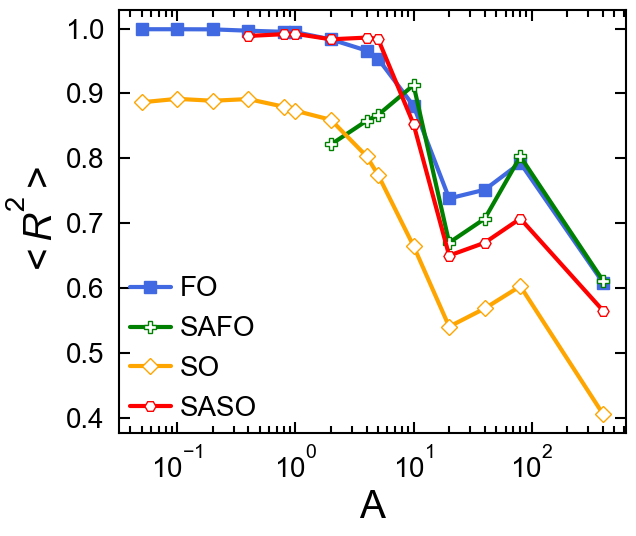

In [4]:
#DO NOT RUN CELL
import itertools
import matplotlib

data_path = '/Users/stephenthomas/Google Drive/Research/2017/Papers/Epoxpy_methods_paper/data/fitting_curing_with_exp_95_percent_fixed_temp_variant/'#fitting_curing_with_exp_95_percent_added_cooling_down/'

names={'iso':'Isothermal','lin_ramp':'Linear Ramp','step':'Step'}
colors={'iso':'C0','lin_ramp':'C1','step':'C2'}
project = signac.get_project(root=data_path)
markers={'iso':'s','lin_ramp':'P','step':'>'}

bonding_periods = [1,5,10,20,40,80,100]
percent_bonds_per_steps = [0.00250,.005,0.01,1]
As = []
for bonding_period in bonding_periods:
    for percent_bonds_per_step in percent_bonds_per_steps:
        As.append(percent_bonds_per_step*(40000./100.)/bonding_period)

As = np.unique(As)
#print(As)
kTs = [0.5,1.0,2.0,4.0,6.0]

models = ['FO','SAFO','SO','SASO']
plt.figure()
    
colors = itertools.cycle(["royalblue", "g", "orange", "r"])
markers = itertools.cycle(["s", "P", "D", "H"])
for model in models:
    Rs = []
    NonZeroAs = []
    ns = []
    for A in As:
        success, n, r,h = fit_sim_data_with_model_plot_wrt_A(data_path,
                                               alpha_inf=95.0,
                                               model=model,
                                               A=A,
                                               kTs=kTs,
                                               plot=False)
        if success:#r > 0:
            NonZeroAs.append(A)
            Rs.append(r)
            ns.append(n)
    color = next(colors)
    marker = next(markers)
    if color is 'royalblue':
        facecolor='royalblue'
    else:
        facecolor='white'
    plt.plot(NonZeroAs,
             Rs,
             color=color,
             label=model,
             marker=marker,
             markeredgewidth=1, 
             markerfacecolor=facecolor,
             markersize=8,
             #linestyle='--',
             markeredgecolor=color)
    #plt.figure(0,figsize=(10,8))
    #plt.plot(NonZeroAs,ns,marker='o',color=color,label=model,markersize=20)
    print(model,NonZeroAs)
    print(Rs)


#plt.figure(0,figsize=(10,8))
#plt.xlabel('A')
#plt.ylabel('Number of temperatures that has a fit')
#plt.xscale('log')
##plt.xlim(-1,50.1)
##plt.ylim(0.8,1.05)
#plt.legend()

#plt.figure(figsize=(15,10))
plt.xlabel('A')
plt.ylabel('$< R^2 >$')
plt.xscale('log')
#plt.xlim(0,90)
#plt.ylim(0.8,1.05)
plt.legend(loc='best')
legend = plt.legend(loc='best', shadow=False, prop={'size':20}, handlelength=1.5, borderaxespad = 0)
#plt.savefig('/Users/stephenthomas/projects/epoxy_methods_manuscript/paper/Images/comparing_all_models.png', transparent=True)

# best_curing_fit

mean H: 0.130831533633


(True, 5, 0.98328000000000004)

/Users/stephenthomas/miniconda3/envs/mbuild_0_7_3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


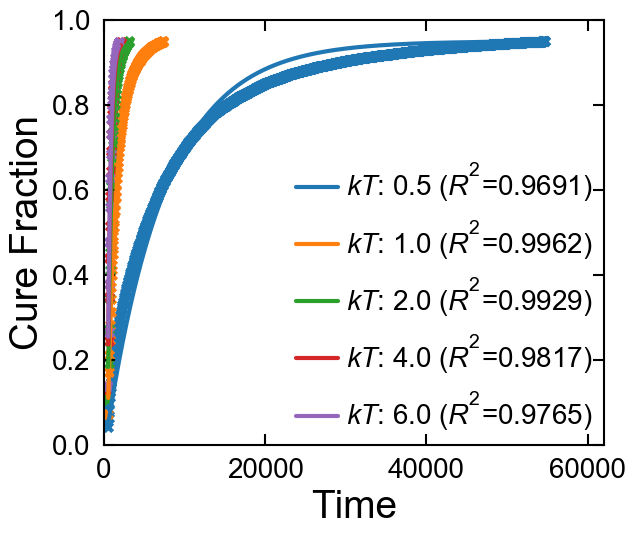

In [30]:
kTs = [0.5,1.0,2.0,4.0,6.0]
save_path='/Users/stephenthomas/projects/epoxy_methods_manuscript/paper/Images/best_curing_fit.png'
fit_sim_data_with_model_plot_wrt_A(data_path,model='FO',
                                   A=2.0,
                                   kTs=kTs,
                                   alpha_inf=95.0,
                                   fit_available=True,
                                   save_path=save_path)


# FO_model_lowA

mean H: 0.0107703447572


(True, 5, 0.99678999999999995)

/Users/stephenthomas/miniconda3/envs/mbuild_0_7_3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


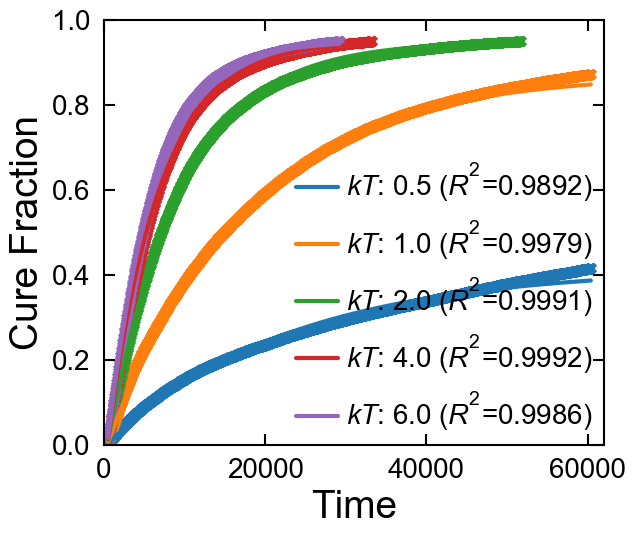

In [31]:
kTs = [0.5,1.0,2.0,4.0,6.0]
save_path='/Users/stephenthomas/projects/epoxy_methods_manuscript/paper/Images/FO_model_lowA.png'
fit_sim_data_with_model_plot_wrt_A(data_path,model='FO',
                                   A=0.1,
                                   kTs=kTs,
                                   alpha_inf=95.0,
                                   fit_available=True,
                                   save_path=save_path)
